<a href="https://colab.research.google.com/github/Yuri-MRQ/nfl_helmet_assignment/blob/master/yolo_helmet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import itertools
import glob
import os
import cv2
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
from multiprocessing import Pool
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from IPython.display import Image
from google.colab.patches import cv2_imshow
import random
import shutil

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [69]:
image_labels = pd.read_csv('/content/drive/MyDrive/Documents/programacao/kaggle/nfl-health-and-safety-helmet-assignment/image_labels.csv')

image_labels.replace('^Helmet', 0, inplace=True, regex=True)

image_labels.head()



,image,label,left,width,top,height
0,57503_000116_Endzone_frame443.jpg,0,1099,16,456,15
1,57503_000116_Endzone_frame443.jpg,0,1117,15,478,16
2,57503_000116_Endzone_frame443.jpg,0,828,16,511,15
3,57503_000116_Endzone_frame443.jpg,0,746,16,519,16
4,57503_000116_Endzone_frame443.jpg,0,678,17,554,17


In [70]:
imgHeight = 720
imgWidth = 1280

#passing center x,y
image_labels.top += image_labels.height/2
image_labels.left += image_labels.width/2

image_labels.top /= imgHeight
image_labels.height /= imgHeight
image_labels.left /= imgWidth
image_labels.width /= imgWidth

changeColumnsOrder = ['image', 'label', 'left',  'top', 'width', 'height']

image_labels = image_labels[changeColumnsOrder]

image_labels.head()

,image,label,left,top,width,height
0,57503_000116_Endzone_frame443.jpg,0,0.864844,0.643750,0.012500,0.020833
1,57503_000116_Endzone_frame443.jpg,0,0.878516,0.675000,0.011719,0.022222
2,57503_000116_Endzone_frame443.jpg,0,0.653125,0.720139,0.012500,0.020833
3,57503_000116_Endzone_frame443.jpg,0,0.589063,0.731944,0.012500,0.022222
4,57503_000116_Endzone_frame443.jpg,0,0.536328,0.781250,0.013281,0.023611


In [ ]:
%mkdir /content/drive/MyDrive/Documents/programacao/kaggle/nfl
%mkdir /content/drive/MyDrive/Documents/programacao/kaggle/nfl/images


In [19]:
def copyfileto(dataset, oldpath, newpath):
    
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    
    for file in dataset:
        
        oldpath_file = os.path.join(oldpath, file)
        newpath_file = os.path.join(newpath, file)

        shutil.copyfile(oldpath_file, newpath_file)


SPLIT_RATE = 0.02010
ROOT_PATH = '/content/drive/MyDrive/Documents/programacao/kaggle/nfl-health-and-safety-helmet-assignment/images'
IMAGE_PATH = '/content/drive/MyDrive/Documents/programacao/kaggle/nfl/images'

imgs_folder_files = os.listdir(ROOT_PATH)
dataset_size = len(imgs_folder_files)

split_dataset_size = int(dataset_size * SPLIT_RATE)

random.shuffle(imgs_folder_files)

train_files = imgs_folder_files[0:dataset_size - split_dataset_size]
val_files = imgs_folder_files[dataset_size - split_dataset_size:dataset_size]

copyfileto(train_files, ROOT_PATH, os.path.join(IMAGE_PATH, 'train'))
copyfileto(val_files, ROOT_PATH, os.path.join(IMAGE_PATH, 'val'))

print('Train File size:', len(train_files))
print('Train File 0:', train_files[0])
print('Val File size:', len(val_files))
print('Val File 0:', val_files[0])


Train File size: 9748
Train File 0: 57604_001387_Sideline_frame0764.jpg
Val File size: 199
Val File 0: 58067_002079_Endzone_frame351.jpg


In [71]:
#helmet is label 0
#so the txt file have every entry as 0 followed by x_center y_center width height
fileBeingProcess = ''
indexToBeTxt = []
file_count = 1
savePath = '/content/drive/MyDrive/Documents/programacao/kaggle/nfl/labels/'

if not os.path.exists(savePath):
    %mkdir /content/drive/MyDrive/Documents/programacao/kaggle/nfl/labels/
if not os.path.exists(os.path.join(savePath, 'train')):
    %mkdir /content/drive/MyDrive/Documents/programacao/kaggle/nfl/labels/train
if not os.path.exists(os.path.join(savePath, 'val')):
    %mkdir /content/drive/MyDrive/Documents/programacao/kaggle/nfl/labels/val
    
def print_progress(present_file, total):
    
    print(f'Processing {present_file}:{total}')

def saveFileTxt(fileBeingProcess, indexToBeTxt, savePath):
    
    fileName = fileBeingProcess.replace('.jpg', '.txt')
    

    dataToTxt = image_labels.loc[indexToBeTxt]
    dataToTxt.drop('image', axis=1, inplace = True)
    dataToTxt.to_csv(os.path.join(savePath, fileName), sep='\t', index=False, header=False)
    

for imageFile, index in zip(image_labels.image, image_labels.index):
    
    
    if fileBeingProcess == '':
        fileBeingProcess = imageFile
        
    if imageFile == fileBeingProcess:
        indexToBeTxt.append(index)
                
    else:
        print_progress(file_count, dataset_size)
        if fileBeingProcess in train_files:
            saveFileTxt(fileBeingProcess, indexToBeTxt, os.path.join(savePath, 'train'))
        elif fileBeingProcess in val_files:
            saveFileTxt(fileBeingProcess, indexToBeTxt, os.path.join(savePath, 'val'))
        else:
            print('Algo deu errado', end='\n')
            
        fileBeingProcess = imageFile
        
        indexToBeTxt = []
        indexToBeTxt.append(index)
        
        file_count += 1
            

if fileBeingProcess in train_files:
    saveFileTxt(fileBeingProcess, indexToBeTxt, os.path.join(savePath, 'train'))
elif fileBeingProcess in val_files:
    saveFileTxt(fileBeingProcess, indexToBeTxt, os.path.join(savePath, 'val'))
else:
    print('Algo deu errado')
    
print_progress(file_count, dataset_size)

A saída de streaming foi truncada nas últimas 5000 linhas.
Processing 4948:9947
Processing 4949:9947
Processing 4950:9947
Processing 4951:9947
Processing 4952:9947
Processing 4953:9947
Processing 4954:9947
Processing 4955:9947
Processing 4956:9947
Processing 4957:9947
Processing 4958:9947
Processing 4959:9947
Processing 4960:9947
Processing 4961:9947
Processing 4962:9947
Processing 4963:9947
Processing 4964:9947
Processing 4965:9947
Processing 4966:9947
Processing 4967:9947
Processing 4968:9947
Processing 4969:9947
Processing 4970:9947
Processing 4971:9947
Processing 4972:9947
Processing 4973:9947
Processing 4974:9947
Processing 4975:9947
Processing 4976:9947
Processing 4977:9947
Processing 4978:9947
Processing 4979:9947
Processing 4980:9947
Processing 4981:9947
Processing 4982:9947
Processing 4983:9947
Processing 4984:9947
Processing 4985:9947
Processing 4986:9947
Processing 4987:9947
Processing 4988:9947
Processing 4989:9947
Processing 4990:9947
Processing 4991:9947
Processing 4992:9

In [3]:
%cd /content/drive/MyDrive/Documents/programacao/kaggle
#!git clone https://github.com/ultralytics/yolov5

/content/drive/MyDrive/Documents/programacao/kaggle


In [4]:
%cd yolov5

# !pip install -r requirements.txt

/content/drive/MyDrive/Documents/programacao/kaggle/yolov5


In [22]:
!wget "https://4.bp.blogspot.com/-xa_pW5qH4CQ/XPmWDpM-EcI/AAAAAAAAC2o/qUsTdJJSprM9OAcjDhBsVj89rryHli0qQCLcBGAs/s1600/japan-220696_1920.jpg"


--2021-10-17 00:35:15--  https://4.bp.blogspot.com/-xa_pW5qH4CQ/XPmWDpM-EcI/AAAAAAAAC2o/qUsTdJJSprM9OAcjDhBsVj89rryHli0qQCLcBGAs/s1600/japan-220696_1920.jpg
Resolving 4.bp.blogspot.com (4.bp.blogspot.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to 4.bp.blogspot.com (4.bp.blogspot.com)|74.125.142.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 624303 (610K) [image/jpeg]
Saving to: ‘japan-220696_1920.jpg’

japan-220696_1920.j 100%[===================>] 609.67K  --.-KB/s    in 0.004s  

2021-10-17 00:35:16 (150 MB/s) - ‘japan-220696_1920.jpg’ saved [624303/624303]



In [33]:
#testing 
!python detect.py --weights yolov5s6.pt --img 640 --conf 0.25 --source japan-220696_1920.jpg


detect: weights=['yolov5s6.pt'], source=japan-220696_1920.jpg, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 2021-10-9 torch 1.9.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Fusing layers... 
Model Summary: 291 layers, 12653596 parameters, 0 gradients
image 1/1 /content/drive/My Drive/Documents/programacao/kaggle/yolov5/japan-220696_1920.jpg: 512x640 18 persons, 1 bicycle, 2 handbags, 1 tie, Done. (0.013s)
Speed: 0.5ms pre-process, 13.5ms inference, 1.3ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp4


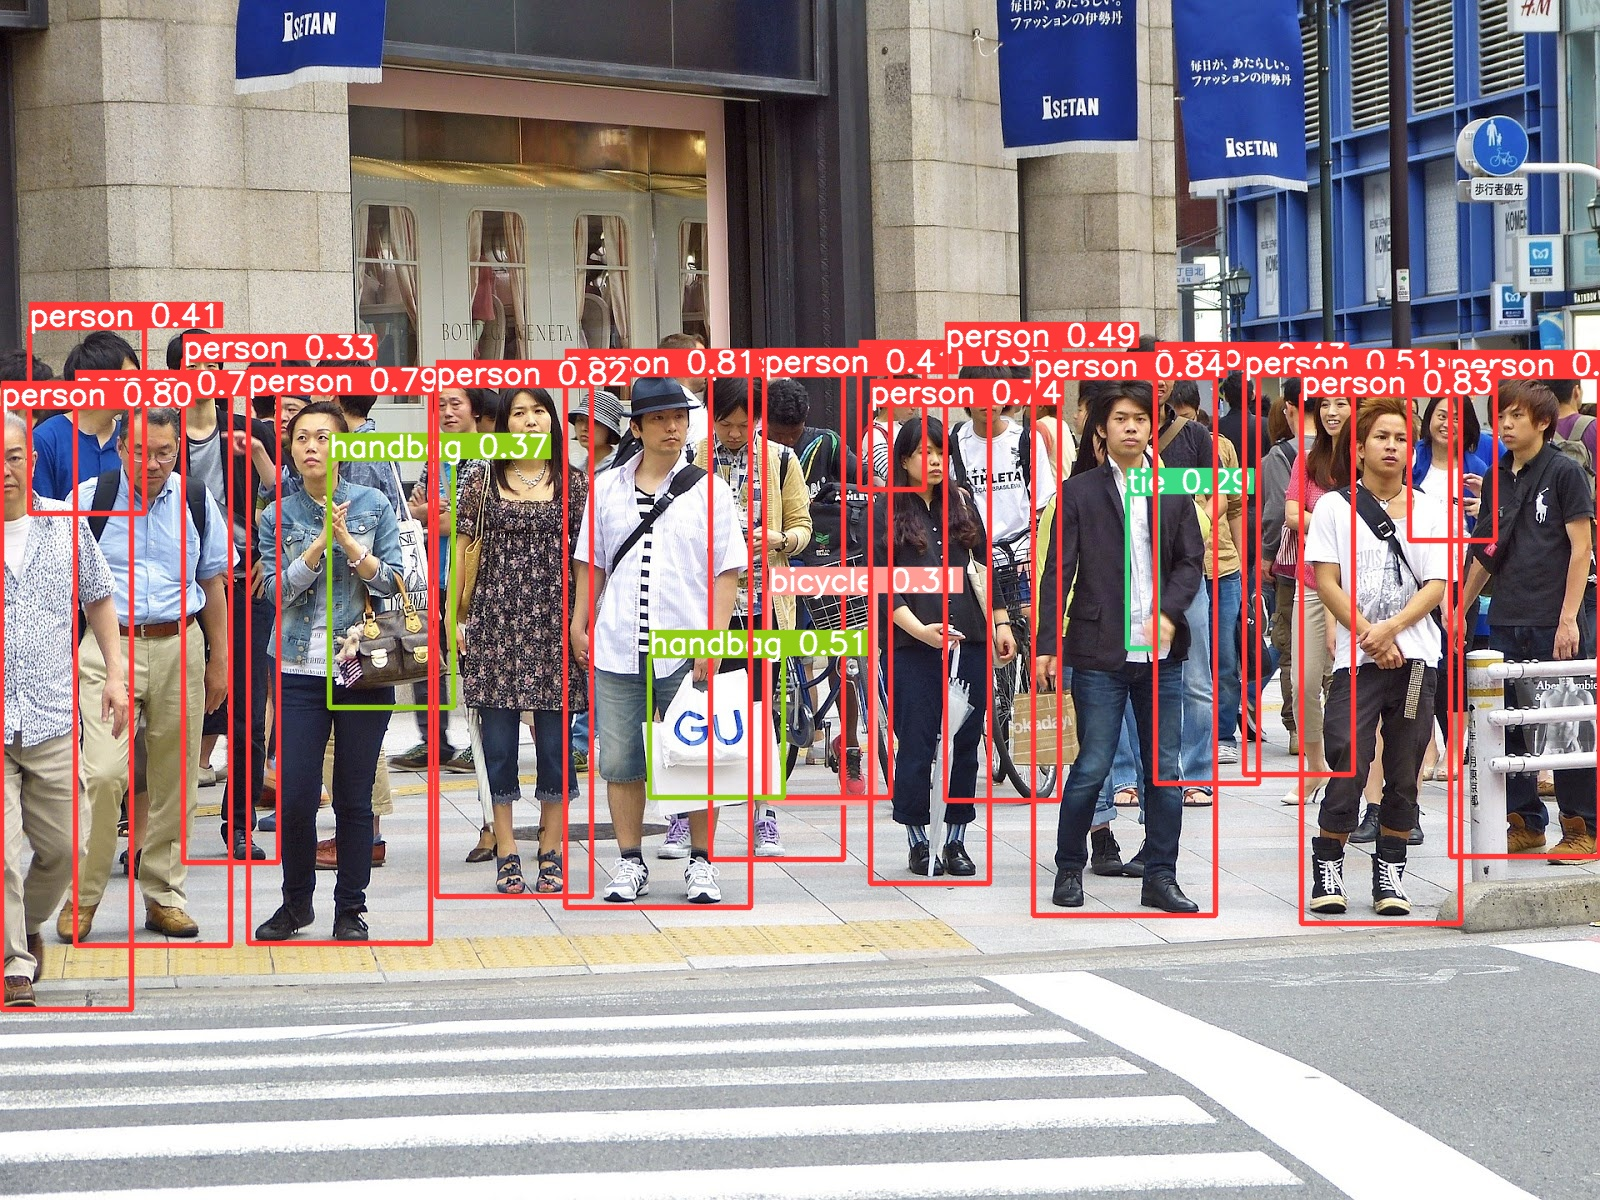

In [34]:
Image('runs/detect/exp4/japan-220696_1920.jpg')

In [8]:
%%writefile helmet.yaml
# https://raw.githubusercontent.com/ultralytics/yolov5/master/data/coco128.yaml
train: /content/drive/MyDrive/Documents/programacao/kaggle/nfl/images/train # 9748 images
val: /content/drive/MyDrive/Documents/programacao/kaggle/nfl/images/val  # 199 images

# number of classes
nc: 1

# class names
names: ['Helmet']

Overwriting helmet.yaml


In [6]:
%pip install -q wandb
import wandb
wandb.login()

     |████████████████████████████████| 1.7 MB 8.7 MB/s 
     |████████████████████████████████| 139 kB 90.5 MB/s 
     |████████████████████████████████| 180 kB 53.3 MB/s 
     |████████████████████████████████| 97 kB 8.5 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [9]:
### Train YOLOv5s on helmet for 15 epochs
!python train.py --img 1280 --batch 16 --epochs 30 --data helmet.yaml --weights yolov5s6.pt --save-period 10



wandb: Currently logged in as: yurimrq (use `wandb login --relogin` to force relogin)
train: weights=yolov5s6.pt, cfg=, data=helmet.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=30, batch_size=16, imgsz=1280, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=10, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 28 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 2021-10-9 torch 1.9.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls

In [5]:

from models.yolo import Model

import torch


In [6]:
# Configurables
yolo_weights_v1 = '/content/drive/MyDrive/Documents/programacao/kaggle/yolov5/runs/train/exp9/weights/best.pt'
BASE_DIR = '/content/drive/MyDrive/Documents/programacao/kaggle/nfl-health-and-safety-helmet-assignment'


debug = False
imgsz = 1280

CONF_THRE = 0.30
CONF_IOU = 0.45

if debug:
    dataset_source = 'train'
else:
    dataset_source = 'test'


In [7]:
import cv2

In [8]:
def compute_color_for_id(label):
    """
    Simple function that adds fixed color depending on the id
    """
    palette = (2 ** 11 - 1, 2 ** 15 - 1, 2 ** 20 - 1)

    color = [((p * (label ** 2 - label + 1)) % 255)/255. for p in palette]
    return tuple(color)

def plot_one_box(frame_data, im, color=None, label=None, line_thickness=3):
    # change x to recive a pd.Dataset, oneline
    # cv2 rectangle use start and end
    # Plots one bounding box on image 'im' using OpenCV

    x_max = frame_data.xmax
    x_min = frame_data.xmin
    y_max = frame_data.ymax
    y_min = frame_data.ymin
    assert im.data.contiguous, 'Image not contiguous. Apply np.ascontiguousarray(im) to plot_on_box() input image.'
    tl = line_thickness or round(0.002 * (im.shape[0] + im.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x_min), int(y_min)), (int(x_max), int(y_max))
    cv2.rectangle(im, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    cv2.circle(im, (int(x_min),int(y_min)), radius=1, color=(255, 255, 255), thickness=-1)
    if label: 
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(im, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(im, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
   
    return im

In [9]:
def show_video(video_path, data_baseline, idx, stop=False, save=False):
  # Create a VideoCapture object and read from input file
  # If the input is the camera, pass 0 instead of the video file name
  video_name = video_path.replace('.mp4', '').split('/')[-1]

  cap = cv2.VideoCapture(video_path)

  if type(data_baseline) == list:
    baseline = pd.DataFrame(data_baseline)
  else:
    baseline = data_baseline

  if save:
    frame_num = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter('result3.mp4',fourcc,fps,(frame_width,frame_height))



  count = 1
  while True:
      cap.set(1, idx)
      success,image = cap.read()

      if success == True:
          # Write the frame into the file 'output.avi'
          baseline_frame = baseline[baseline.video_frame == f'{video_name}_{idx}']

          for i in range(len(baseline_frame)):
              
              img = plot_one_box(baseline_frame.iloc[i], image, color=(0,0,0), label=None, line_thickness=3)

          if save:
            out.write(img)
          
          # Display the resulting frame    
          cv2_imshow(img)
          break

          # Press Q on keyboard to stop recording
          if cv2.waitKey(1) & 0xFF == ord('q'):
              break

      # Break the loop
      else:
          break  
  #     
      
  # When everything done, release the video capture and video write objects
  cap.release()
  if save:
    out.release()

  # Closes all the frames
  cv2.destroyAllWindows()

In [10]:
from utils.datasets import LoadImages
from utils.general import check_img_size

type_dataset = 'train' if debug else 'test'
debug_img = [1, 2, 3]

# Model
model = torch.hub.load('', 'custom', path=yolo_weights_v1, source='local')  # or yolov5m, yolov5l, yolov5x, custom

model.conf = CONF_THRE  
model.iou = CONF_IOU

stride = int(model.stride.min())  # model stride
imgsz = check_img_size(imgsz, s=stride)
try:
  BASE_VIDEO_PATH = f'/content/drive/My Drive/Documents/programacao/kaggle/nfl-health-and-safety-helmet-assignment/{type_dataset}/' 
  os.path.exists(BASE_VIDEO_PATH)
except:
  BASE_VIDEO_PATH = f'/content/drive/MyDrive/Documents/programacao/kaggle/nfl-health-and-safety-helmet-assignment/{type_dataset}/' 

baseline = []
    
source_path = f'../nfl-health-and-safety-helmet-assignment/{type_dataset}'


dataset = LoadImages(source_path, img_size=imgsz,  stride=stride)
previous_file = ''

idx= 1

for frame_idx, (path, img, im0s, vid_cap) in enumerate(dataset):
  print(end="\n")
  # Inference
  results = model(img)
  
  source =  path.replace(BASE_VIDEO_PATH, '')

  
  if source != previous_file:
      previous_file = source
      idx = 1
  
  video_frame_name = source.replace('.mp4', '_{}'.format(idx))
  frame_bbox =  results.pandas().xyxy[0]
  

  if (
      'video_frame'not in frame_bbox.columns or
      'left'not in frame_bbox.columns or
      'width'not in frame_bbox.columns or
      'height'not in frame_bbox.columns
  ):

      frame_bbox.insert(loc= 0,column = 'height', value= 0)
      frame_bbox.insert(loc= 0,column = 'top', value= 0)
      frame_bbox.insert(loc= 0,column = 'width', value= 0)
      frame_bbox.insert(loc= 0,column = 'left', value= 0)
      frame_bbox.insert(loc= 0,column = 'video_frame', value= video_frame_name)
  
  
  # if debug and idx in debug_img:
  #     show_video(path, frame_bbox, idx, stop=2)

  frame_bbox.left = frame_bbox.xmin
  frame_bbox.top = frame_bbox.ymin
  frame_bbox.width = (frame_bbox.xmax - frame_bbox.xmin)
  frame_bbox.height = (frame_bbox.ymax - frame_bbox.ymin)

  #drop everything unecessary
  frame_bbox.drop(columns= ['class', 'name', 'xmax', 'ymax', 'xmin', 'ymin'], inplace= True)

  #verify constrains
  width_constrain = (frame_bbox.left + frame_bbox.width) > 1280
  heigth_constrain = (frame_bbox.top + frame_bbox.height) > 720

  width_constrain_index = width_constrain.index[width_constrain == True]
  heigth_constrain_index = heigth_constrain.index[heigth_constrain == True]

  for index in width_constrain_index:
      diff = frame_bbox.loc[index, 'left'] + frame_bbox.loc[index, 'width'] - 1280
      frame_bbox.loc[index, 'width'] -= diff
  for index in heigth_constrain_index:
      diff = frame_bbox.loc[index, 'top'] + frame_bbox.loc[index, 'height'] - 720
      frame_bbox.loc[index, 'height'] -= diff
  frame_bbox.rename(columns={'confidence': 'conf'}, inplace=True)

  # making one file
  baseline.append(frame_bbox)
  
  idx += 1

    
final_baseline = pd.concat(baseline)

final_baseline.to_csv(f'{type_dataset}_baseline_helmet.csv', index=False)
    


requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13

requirements: 1 package updated per /content/drive/MyDrive/Documents/programacao/kaggle/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



YOLOv5 🚀 v5.0-500-g276b674 torch 1.9.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Fusing layers... 
Model Summary: 291 layers, 12349288 parameters, 0 gradients
Adding AutoShape... 


video 1/6 (1/434) /content/drive/My Drive/Documents/programacao/kaggle/nfl-health-and-safety-helmet-assignment/test/57906_000718_Endzone.mp4: 
video 1/6 (2/434) /content/drive/My Drive/Documents/programacao/kaggle/nfl-health-and-safety-helmet-assignment/test/57906_000718_Endzone.mp4: 
video 1/6 (3/434) /content/drive/My Drive/Documents/programacao/kaggle/nfl-health-and-safety-helmet-assignment/test/57906_000718_Endzone.mp4: 
video 1/6 (4/434) /content/drive/My Drive/Documents/programacao/kaggle/nfl-health-and-safety-helmet-assignment/test/57906_000718_Endzone.mp4: 
video 1/6 (5/434) /content/drive/My Drive/Documents/programacao/kaggle/nfl-health-and-safety-helmet-assignment/test/57906_000718_Endzone.mp4: 
video 1/6 (6/434) /content/drive/My Drive/Documents/programacao/kaggle/nfl-health-and-safety-helmet-assignment/test/57906_000718_Endzone.mp4: 
video 1/6 (7/434) /content/drive/My Drive/Documents/programacao/kaggle/nfl-health-and-safety-helmet-assignment/test/57906_000718_Endzone.mp4: 